# Compare HUX Technique results with in-situ spacecraft observations


In [105]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from heliopy.data import psp
from heliopy.data import omni
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import copy

from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
from pathlib import Path
from parfive import Downloader
from scipy.interpolate import interpn

# matplotlib fontsize
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

# Read in global MHD model (MAS) CR2210 solutions 

Download MAS solutions from the web - see base_url

In [106]:
download_dir = Path.cwd() / '..' / '..' / 'data'

mas_helio_dir = download_dir / 'mas_helio'
mas_helio_dir.mkdir(parents=True, exist_ok=True)
base_url = 'http://www.predsci.com/data/runs/cr2210-medium/hmi_mast_mas_std_0201/helio/{var}002.hdf'

# Create a downloader to queue the files to be downloaded
dl = Downloader()

vars = ['rho', 'vr', 'br']
for var in vars:
    file = mas_helio_dir / f'{var}002.hdf'
    if file.exists():
        continue
    else:
        remote_file = base_url.format(var=var)
        dl.enqueue_file(remote_file, path=mas_helio_dir)

# Download the files
if dl.queued_downloads > 0:
    dl.download()
mas_path = mas_helio_dir.resolve()

In [107]:
#mas_path = sample_data.mas_helio()
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [108]:
# read in MHD velocity results. 
vr_model = model['vr']

In [109]:
# save MHD mesh coordinates. 
# phi - (0, 2*pi)
p = vr_model.phi_coords
# sin(theta) - (-1, 1)
t = vr_model.theta_coords
# 30 solar radii to approx 1 AU
r = vr_model.r_coords
# velocity profile 
f = vr_model.data

In [110]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)

Velocity matrix shape:  (128, 111, 140)
Phi dim:  128
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [111]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_plot = np.append(p, 2*np.pi) 

# Phi: from radians to degrees. longitude.
p_plot = (180/np.pi)*p_plot

In [112]:
# append the first slice p=0 to velocity matrix. 
f_plot = np.append(f,[f[0,:, :]],axis=0)

In [113]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r_plot = (695700)*r

In [114]:
# convert to sin(Lat.) [-1, 1]
t_plot = np.sin(t)

In [115]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p_plot[0]], 0.5 * (p_plot[1:] + p_plot[:-1]), [p_plot[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

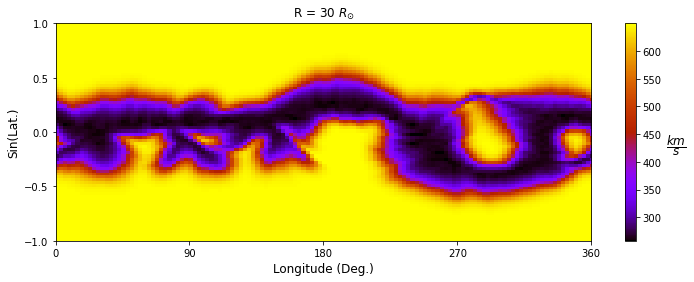

In [116]:
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
plt.savefig('figures/vr_30rs_map.png')

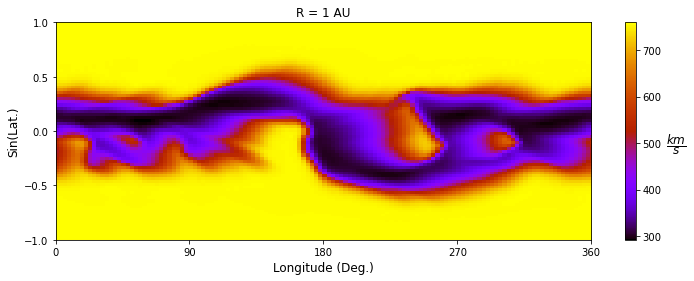

In [117]:
fig, ax = plt.subplots(figsize = (12,4))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
plt.savefig('figures/vr_1au_map.png')

# Apply HUX-f

In [118]:
def apply_hux_f_model(r_initial, r, p, dr_vec, dp_vec, alpha, rh, add_v_acc=True, omega_rot=(2*np.pi)/(25.38*86400)):
    """ Apply 1d upwind model to the inviscid burgers equation. r/phi grid."""
    
    v = np.zeros((len(r), len(p))) # initialize array vr.
    v[0, :] = r_initial

    if add_v_acc:
        v_acc = alpha * (v[0, :]*(1 - np.exp(-r[0]/rh)))
        v[0, :] = v_acc + v[0, :]

    for i in range(len(r) -1):
        for j in range(len(p)):

            if j == len(p) -1: # force periodicity 
                v[i+1, j] = v[i+1, 0]

            else:
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v[i,j]) > 1:
                    print(dr_vec[i] - dp_vec[j]*v[i,j]/omega_rot) 
                    print(i, j) # courant condition

                frac1 = (v[i, j + 1] - v[i, j]) / v[i, j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v[i + 1, j] = v[i, j] + frac1*frac2
            
    return v

In [119]:
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
dr_vec=r_plot[1:] - r_plot[:-1]
dp_vec=p[1:] - p[:-1]

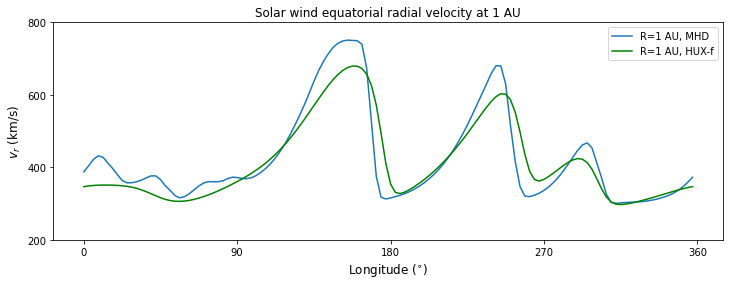

In [120]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,4))
_ = ax.plot(p*180/np.pi, solar_equator_r_1_au, label="R=1 AU, MHD")
_ = ax.plot(p*180/np.pi, apply_hux_f_model(solar_equator_r_30_radii, r, p, dr_vec, dp_vec, 0.15, 50)[-1, :], 'g',label="R=1 AU, HUX-f")
_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU",fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/vr_1AU_ts_comp_MHD_HUX-f_.png')

In [121]:
hux_f_res = np.ones((len(p), len(t), len(r)))
for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], r, p, dr_vec, dp_vec, 0.15, 50).T

In [122]:
hux_f_res_plot = np.append(hux_f_res,[hux_f_res[0,:, :]],axis=0)

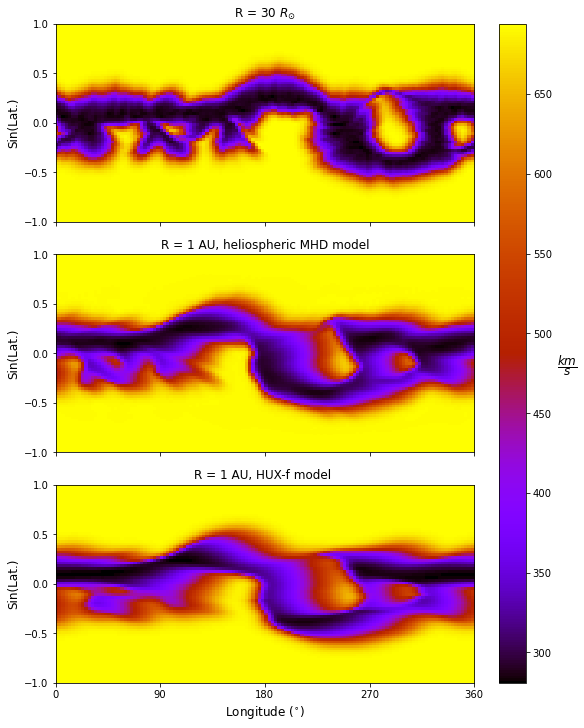

In [123]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=3, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax[0].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)


ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 1 AU, heliospheric MHD model", fontsize=fs1)
ax[1].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, HUX-f model ", fontsize=fs1)
ax[2].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[2].set_xlabel("Longitude ($^{\circ}$)", fontsize=fs1)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, hux_f_res_plot[:, :, -1].T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)

plt.savefig('figures/vr_lon_lat_maps_30rs_MHD_HUX-f.png')

# Read in PSP observations

Here we load the merged magnetic field and plasma data product, which has
an hourly data cadence.

In [124]:
starttime = '2018-10-26'
endtime = '2018-11-23'
psp_data = psp.merged_mag_plasma(starttime, endtime)
print(psp_data.columns)

['radialDistance', 'heliographicLatitude', 'heliographicLongitude', 'BR', 'BT', 'BN', 'B', 'VR', 'VT', 'VN', 'ProtonSpeed', 'flow_theta', 'flow_lon', 'protonDensity', 'protonTemp']


In [125]:
psp_data.data

,radialDistance,heliographicLatitude,heliographicLongitude,BR,BT,BN,B,VR,VT,VN,ProtonSpeed,flow_theta,flow_lon,protonDensity,protonTemp
Time,,,,,,,,,,,,,,,
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26 01:00:00,0.37,1.9,321.000000,-11.10,7.53,-5.21,14.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0
2018-11-22 23:00:00,0.48,2.0,197.600006,17.57,-1.06,1.15,17.639999,391.799988,36.400002,4.2,393.5,0.6,5.3,27.1,129254.0


Generate the PSP trajectory.

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.



In [126]:
times = psp_data.index

spicedata.get_kernel('psp')
spicedata.get_kernel('psp_pred')
psp_traj = spice.Trajectory('SPP')
psp_traj.generate_positions(times, 'Sun', 'IAU_SUN')
psp_coords = psp_traj.coords

Take a sample of the radial velocity.

Here we start by getting the radial velocity `Variable` from the model, and
then use the PSP corodinate information to sample it.


In [127]:
hux_model = copy.deepcopy(vr_model)
hux_model.data.data = hux_f_res

In [128]:
vr_sampled_hux = hux_model.sample_at_coords(psp_coords.lon,
                                            psp_coords.lat,
                                            psp_coords.radius)

vr_sampled_mhd = vr_model.sample_at_coords(psp_coords.lon,
                                           psp_coords.lat,
                                           psp_coords.radius)

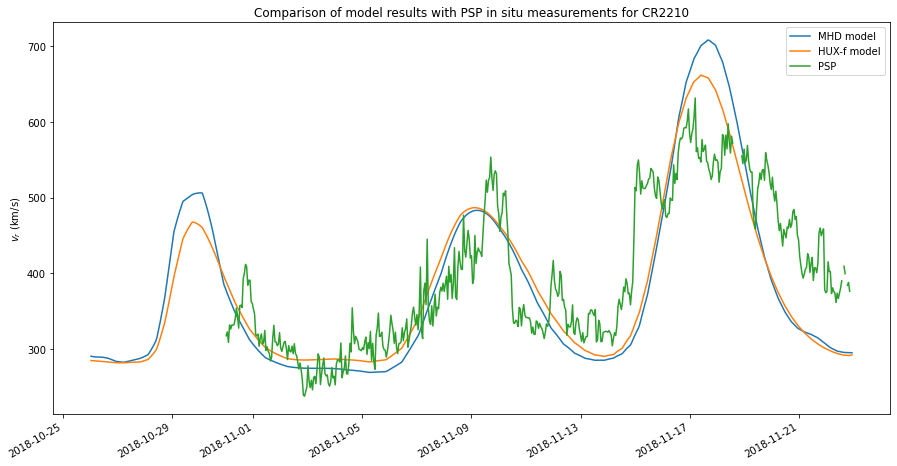

In [129]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(times, vr_sampled_mhd, label='MHD model')
ax.plot(times, vr_sampled_hux, label='HUX-f model')
ax.plot(times, psp_data.quantity('VR'), label='PSP')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
fig.autofmt_xdate()

plt.savefig('figures/psp_comparison_cr2210_time.png')

In [130]:
# lon unit = degree
lon_psp = psp_data.data["heliographicLongitude"].array.to_numpy()
# lat unit = degree
lat_psp = psp_data.data["heliographicLatitude"].array.to_numpy()
# radius unit = AU
r_psp = psp_data.data["radialDistance"].array.to_numpy()
# velocity unit = km/sec
vr_psp = psp_data.data["VR"].array.to_numpy()

In [131]:
# convert lat to -pi/2 to pi/2
lat_psp_rad = (np.pi/180)*lat_psp
# convert radial distance from AU to solar radii
r_psp_rs = r_psp*215.032

In [132]:
mhd_traj = interpn((p_plot,t,r), f_plot, np.array([lon_psp,lat_psp_rad,r_psp_rs]).T)
hux_traj = interpn((p_plot,t,r), hux_f_res_plot, np.array([lon_psp,lat_psp_rad,r_psp_rs]).T)

In [133]:
min_indx = np.argmin(lon_psp)
#plt.plot(lon_psp)

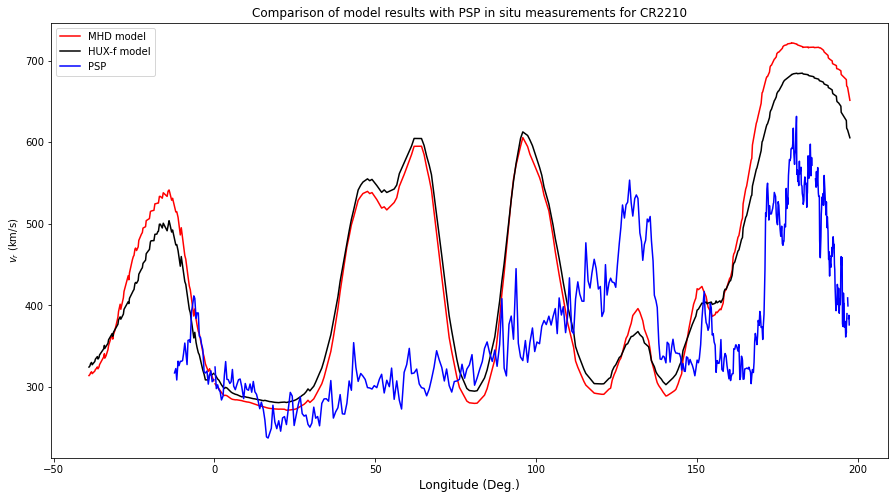

In [134]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lon_psp[:min_indx]-360, mhd_traj[:min_indx], color="r", label="MHD model")
ax.plot(lon_psp[:min_indx]-360, hux_traj[:min_indx], color="k", label="HUX-f model")
ax.plot(lon_psp[:min_indx]-360, vr_psp[:min_indx], color="b", label="PSP")

ax.plot(lon_psp[min_indx:], mhd_traj[min_indx:], color="r")
ax.plot(lon_psp[min_indx:], hux_traj[min_indx:], color="k")
ax.plot(lon_psp[min_indx:], vr_psp[min_indx:], color="b")

ax.set_ylabel(r'$v_{r}$ (km/s)')
#ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of model results with PSP in situ measurements for CR2210")
ax.legend()
plt.savefig('figures/psp_comparison_cr2210_carrington_longitude.png')

# Read in Earth (OMNI) data